<a href="https://colab.research.google.com/github/ayahamer/Signal-Processing/blob/main/Signals_PART_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import io
import scipy.integrate as integrate
import scipy.special as special
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
from matplotlib.font_manager import ft2font
import wave
from scipy.io import wavfile


In [ ]:
# uplaoding audio file. samplerate is the sample rate of the original file (48kHz). stores the file in the data array
samplerate, data = wavfile.read('PartB.Original.wav')

# getting the length of audio file
duration = data.shape[0] / samplerate

# finding the total time of the stream (10.115 seconds)
timespaced = np.arange(0,duration,3/samplerate)


samprate = 16000 #creating a variable with a desired sample rate of 16kHz

# downsampling to 16k Hz
if samplerate > samprate:
    downsample = samplerate // samprate # creating a new variable which takes the quotient of the two values and ignores the fractional portion
    data = data[::downsample] # selects every 'downsampled element in the data array. this takes every 3rd element in this case.
    samplerate = samprate #setting the original samplerate to the desired samplerate

# make sure there is only 1 channel and not 2
if len(data.shape) > 1 and data.shape[1] == 2:
    data = data[:, 0]

#UP TO THIS POINT: Now, 'data' contains the downsampled original audio file, now at 16KHz

In [ ]:
chunklength = 40 #length of each chunk in ms

chunksize = int(samplerate*chunklength/1000) #chunk size in samples
allchunks = [data[i:i + chunksize] for i in range(0, len(data), chunksize)] #

#UP TO THIS POINT: Now, 'allchunks' is an array of arrays, with each subarray containing one chunk (480 elements of 'data')

Text(0.5, 1.0, 'Original Audio Time Stream')

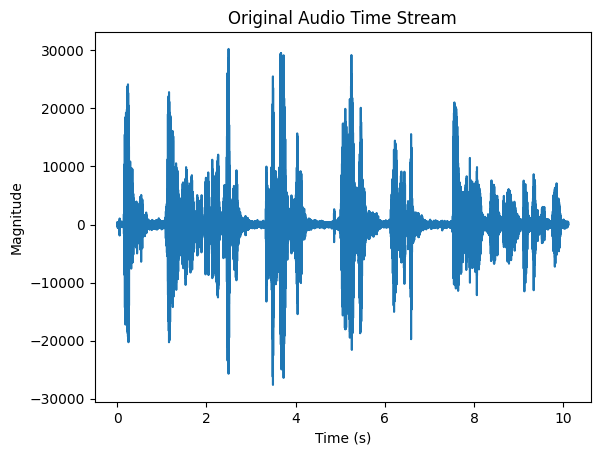

In [ ]:
#plotting the time stream of the original file
plt.plot(timespaced, data)
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.title('Original Audio Time Stream')



In [ ]:
def plot_fourier_transform(data, title, sampling_rate=16_000): # creating a function that takes input parameters 'data', 'title' and 'sampling_rate' to plot the Fourier transform of the data
  fftresult = np.fft.fft(data) #recording the results of an FFT of 'data' in 'fftresult'

  #Taking only the positive frequencies
  n = len(data) #making 'n' the length of 'data'
  freq = np.fft.fftfreq(n, 1/sampling_rate) #freq is now an array of frequency values from the FFT
  positive_frequencies = freq[:n//2] #isolating the positive frequencies from the freq array
  magnitude = np.abs(fftresult)[:n//2] #calculates magnitudes of positive frequency elements

  # Ploting the FFT
  plt.plot(positive_frequencies, magnitude) #plots graph
  plt.xlabel('Frequency (Hz)') #adds x-axis label
  plt.ylabel('Magnitude') #adds y-axis label
  plt.title(title) #add title
  plt.show() #display graph

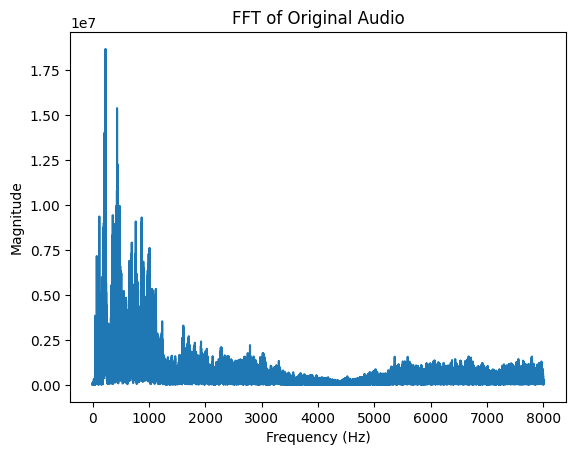

In [ ]:
plot_fourier_transform(data,'FFT of Original Audio' ) #calls the plot_fourier_transform function to plot the data and provides it the title of graph

In [ ]:
centrefreqs = np.linspace(0, 7500, int(7500/50 + 1)) # array of 0, 50, 100, ... 7500 for the centre frequencies

finalallchunks = [] #declares empty array
bandwidth = 100 #sets our bandwidth length for filters

for i, chunk in enumerate(allchunks): #creates loop to go through the array allchunks and use its values
  chunklength = len(chunk) #gives chunklength the length of the current chunk
  starttime = i*chunklength #i is index, gives starttime variable the right overall starting location in the file
  endtime = starttime + chunklength #gives endtime variable the right overall ending location in the file
  t = np.arange(starttime, endtime) #gives array of values in between starttime and endtime with difference of 1
  t_seconds = t / samprate #converts the time to seconds
  synthesizedchunks = [] #declares empty array
  for index, centrefreq in enumerate(centrefreqs): #creates loop to go through centrefreqs and use its values
    lowfreq = centrefreq - bandwidth/2 #calculates the low frequency based on the bandwidth and centre frequency
    highfreq = centrefreq + bandwidth/2 #calculates the high frequency based on the bandwidth and centre frequency
    if lowfreq < 1: #activates the following line of code if the lowfrequency is less than one as an edge case
      lowfreq = 1 #since it doesn't work if lowfreq is <1, if it is, this just sets it to one to bypass the error
    filter = signal.butter(2, [lowfreq, highfreq], btype="bandpass", output="sos", fs=samprate) #creates a bandpass filter of order 2 with the low and high frequency values
    filteredchunk = signal.sosfilt(filter, chunk) #applies the filter to the chunk
    rms = np.sqrt(np.mean(filteredchunk**2)) #Calculate the RMS of this particular filtered chunk
    synthesizedchunk = rms*np.sin(2*np.pi*centrefreq*t_seconds) #synthesizes a chunk with the sin formula provided
    synthesizedchunks.append(synthesizedchunk) #adds the synthesized chunk to an array

  finalallchunks.append(np.sum(synthesizedchunks, axis=0)) #Add all the synthesized chunks from that one chunk
concatarray = np.concatenate(finalallchunks, axis=0) #connects the chunks from the array

In [ ]:
with wave.open("output.wav", 'w') as output_file: #opens a WAV file, and creates object called output_file to write it to
        output_file.setparams((1, 2, 16000, len(concatarray), "NONE", "Uncompressed")) #gives parameters of the new audio file
        output_file.writeframes(concatarray.astype(np.int16).tobytes()) #writes the synthesized chunks to the new file

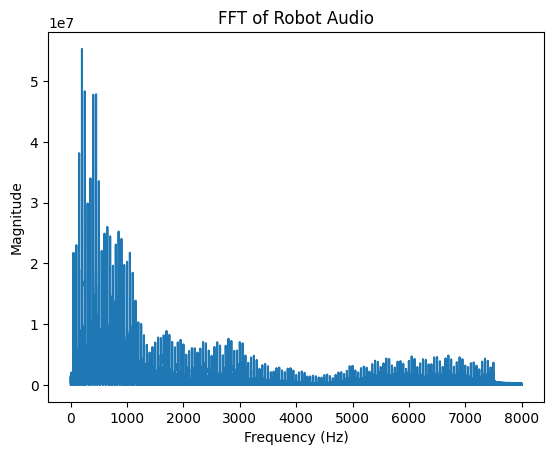

In [ ]:
plot_fourier_transform(concatarray, 'FFT of Robot Audio') #uses the plot_fourier_transform function to plot the new FFT

Text(0.5, 1.0, 'Robotic Audio Time Stream')

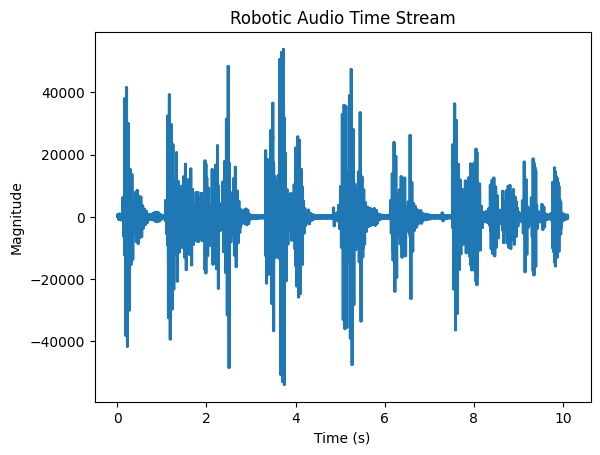

In [ ]:
plt.plot(timespaced, concatarray) #plots the final audio file against time
plt.xlabel('Time (s)') #adds x-axis label
plt.ylabel('Magnitude') #adds y-axis label
plt.title('Robotic Audio Time Stream') #adds graph title